Name: Aidan Fischer
Class: MA 541 Spring 2023 Final Project
Title: Sparse Coding and Learning Dictionaries of Image Patches
Dataset: https://www.kaggle.com/datasets/kamino/largescale-common-watermark-dataset
  Kaggle lists dataset as public domain
  Testing and training sets combined, since algorith works on single images
  Contains 60000 watermarked images
I pledge my honor that I have abided by the Stevens Honor System

Abstract: 
    Dictionaries allow for compressed representations of large datasets of numerical data by encoding that dataset as a sparse matrix of coefficients of the atoms in the dictionary. Images are a prime example of large numerical matrices. However, instead of treating each row or column as a data vector, it is more useful to consider the set of image patches available in an image. By learning a dictionary from image patches, we can represent an image as a matrix of coefficients of the dictionary atoms

Introduction:
    Originally, I planned on doing a project on watermark removal. However, not only does dictionary learning take too long for this to be a practical method for doing that, I also couldn't get the dictionary to learn how to ignore the watermark. Even excluding the watermarked portion of the image from the training set did not get rid of enough information for the watermark to disappear from the reconstruction. Therefore, I decided to just have the project be on sparse coding and dictionary learning. Dictionary learning can be a good way to reduce the size of a dataset by encoding the dataset as a sparse matrix of coefficients in a linear combination of the dictionary's atoms. By learning a dictionary of image patches, we can compactly represent an image as such a sparse matrix. 

What I have accomplished:
    I have implemented dictionary learning for image patches. The first section of my code represents my efforts to get the algorithms in the papers from my original project idea. They do not work, and are far too slow for me to continue to debug. From there, I implemented the Mini Batch version of dictionary learning from scikit learn and learned a variety of dictionaries from images, with varying parameters to tell what had the most effect on the quality of the resulting reconstruction. I followed learning the dictionary with getting the code representation of the original image, then reconstructing that code matrix into a matrix of patches and rebuilding the image from the learned patches. Below are the resulting images.

Unless otherwise noted, dictionaries trained on strip with height = 1/20 of image height
Unless otherwise noted, dictionaries trained with a batch size of 256 patches
Original Image


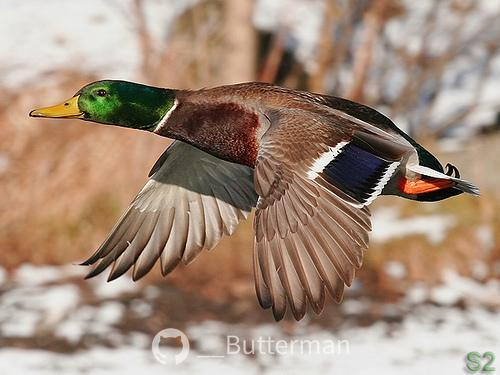

Reconstructed Image, k = 2


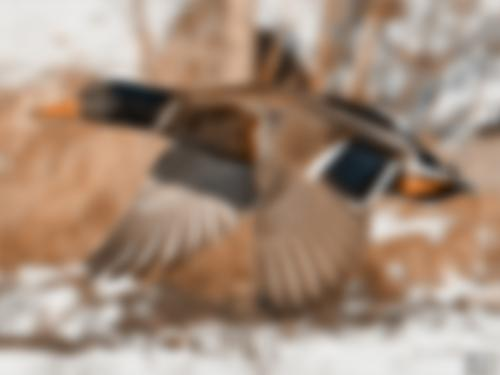

Reconstructed Image, k = 4


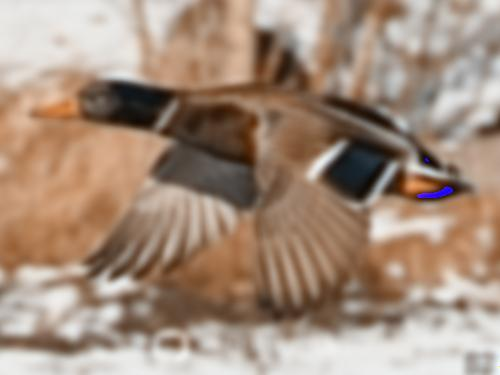

Reconstructed Image, k = 8


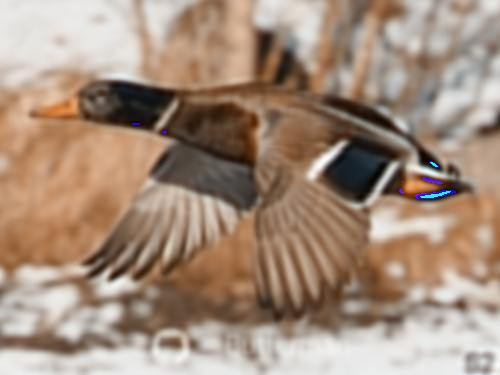

Reconstructed Image, k = 16


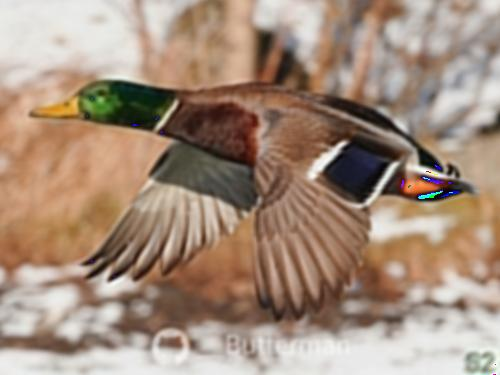

Reconstructed Image, k = 32


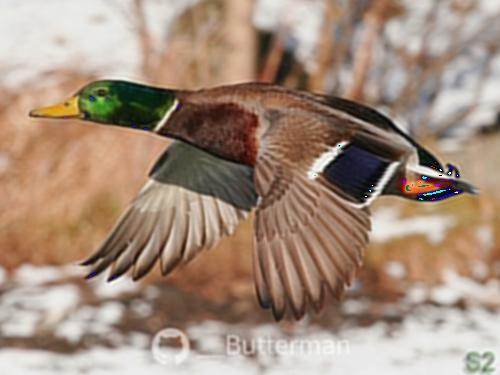

Reconstructed Image, k = 64


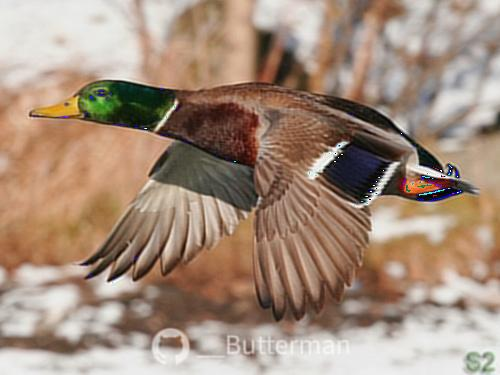

Reconstructed Image, k = 64, smaller train strip


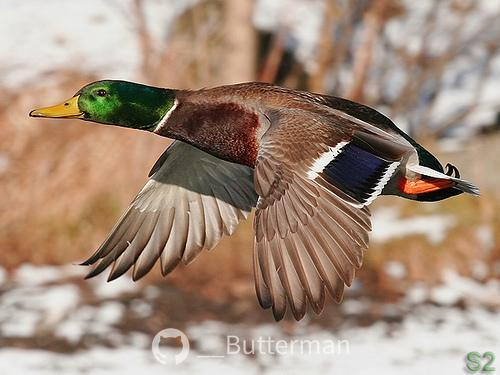

Second Image


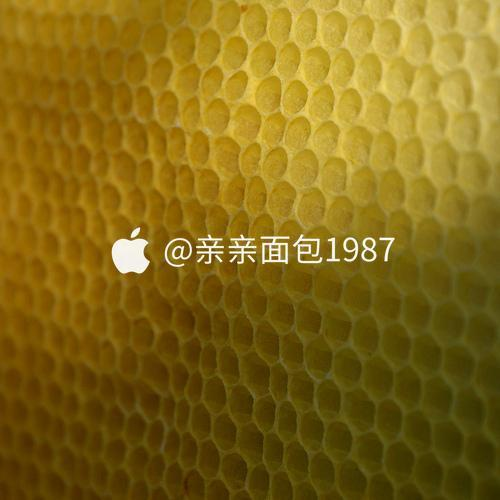

Second Image Reconstruction, k = 64, trained on full image


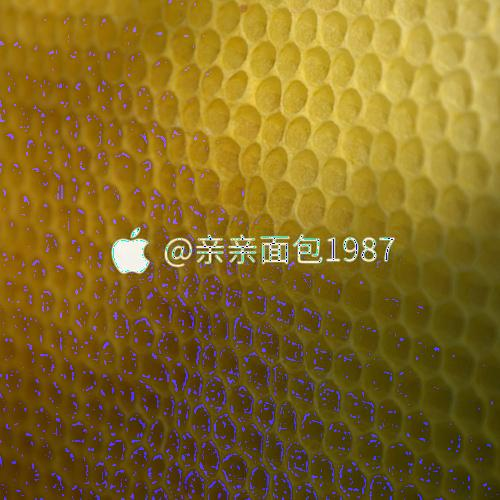

Second Image Reconstruction, k = 64


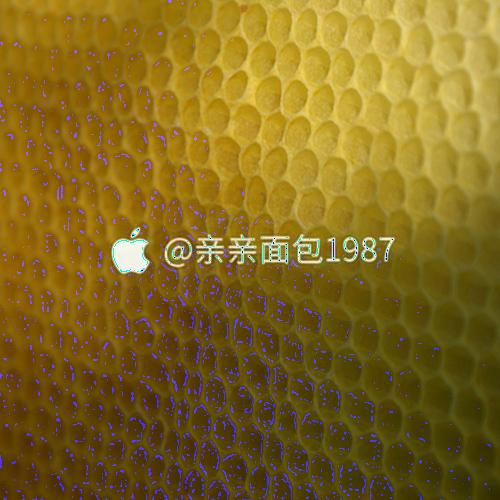

Second Image Reconstruction, k = 128, trained on full image


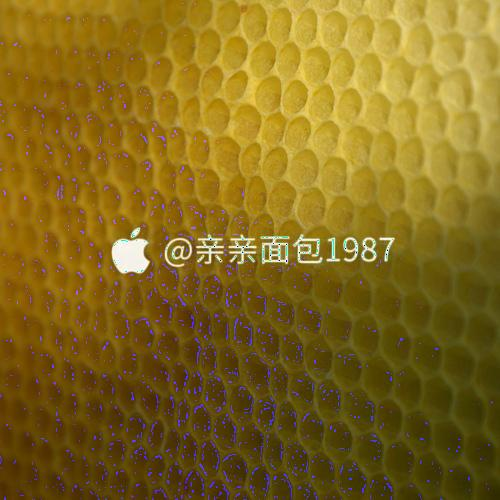

Second Image Reconstruction, k = 128, trained on full image


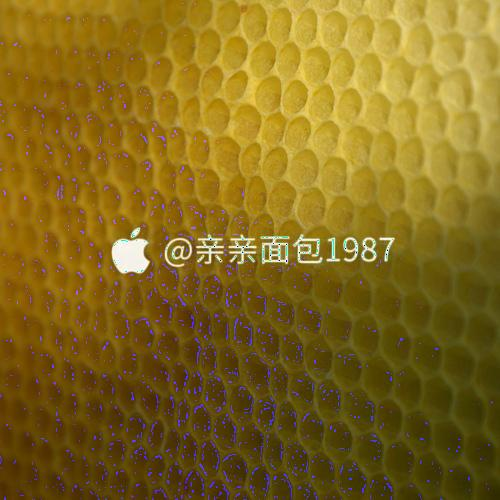

Second Image Reconstruction, k = 256, trained on full image, batch size 32


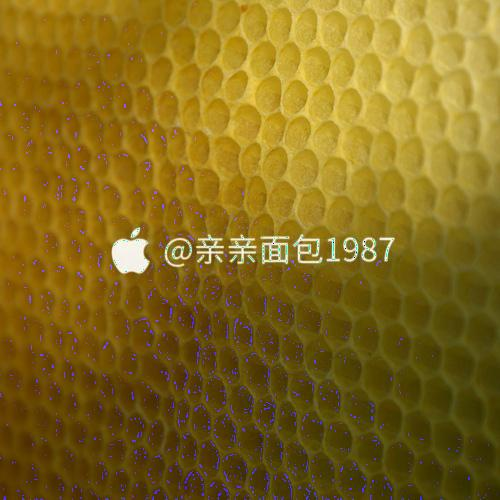

Second Image Reconstruction, k = 256, trained on full image, batch size 128


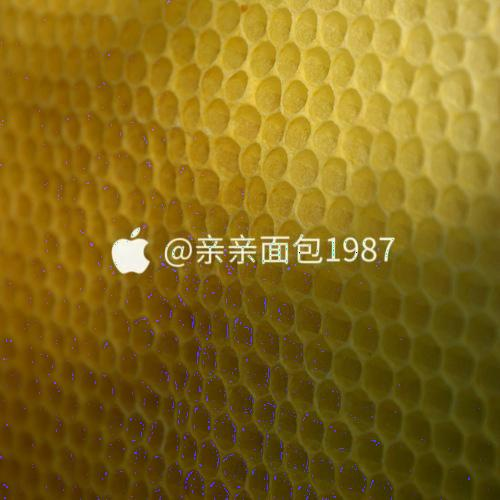

In [7]:
print("Unless otherwise noted, dictionaries trained on strip with height = 1/20 of image height")
print("Unless otherwise noted, dictionaries trained with a batch size of 256 patches")
print("Original Image")
display(Image.open("test.jpg"))
print("Reconstructed Image, k = 2")
display(Image.open("test2.jpg"))
print("Reconstructed Image, k = 4")
display(Image.open("test4.jpg"))
print("Reconstructed Image, k = 8")
display(Image.open("test8.jpg"))
print("Reconstructed Image, k = 16")
display(Image.open("test16.jpg"))
print("Reconstructed Image, k = 32")
display(Image.open("test32.jpg"))
print("Reconstructed Image, k = 64")
display(Image.open("test64.jpg"))
print("Reconstructed Image, k = 64, smaller train strip")
display(Image.open("test64_less.jpg"))
print("Second Image")
display(Image.open("test_other.jpg"))
print("Second Image Reconstruction, k = 64, trained on full image")
display(Image.open("test64_full_other.jpg"))
print("Second Image Reconstruction, k = 64")
display(Image.open("test64_other.jpg"))
print("Second Image Reconstruction, k = 128, trained on full image")
display(Image.open("test128_full_other.jpg"))
print("Second Image Reconstruction, k = 128, trained on full image")
display(Image.open("test128_full_other.jpg"))
print("Second Image Reconstruction, k = 256, trained on full image, batch size 32")
display(Image.open("test256_full_other_b32.jpg"))
print("Second Image Reconstruction, k = 256, trained on full image, batch size 128")
display(Image.open("test256_full_other_b128.jpg"))

Observations:
    Training a dictionary takes a long time, even with small training strips of patches and a small k (and such conditions result in a poor reconstruction anyway)
    The single largest factor in image reconstruction quality seems to be having a sufficiently large k
    Too small k, and the image is blurry and/or has inaccurate colors
    At sufficient k, the increase in quality gained from increasing k further plateaus 
    Batch size does not seem to effect quality too much, but smaller batch sizes results in slower training. 
    Test strip can be really small, but too small and it might not work
    Certain images, like the second image in the example results above, seem to have artifacts regardless of parameters used

Conclusion:
    Dictionary learning is useful because it allows for a compact representation of a very large dataset when some loss in data accurary is acceptable. However, it seems more useful for use cases such as denoising of an image by using a dictionary trained on known data that isn't noisy. I did not have time to implement this, and similar, use cases once I gave up on my original project. Otherwise, I find it very interesting that such a small proportion of an image is able to give the dictionary enough information to reconstruct the entire image when the image is encoded through the dictionary. 

References:
    While I didn't end up following my original project, some of my code still attempts to implement the algorithms from these papers, so I'll include them here
    Julien Mairal, Francis Bach, Jean Ponce, and Guillermo Sapiro. 2009. Online dictionary learning for sparse coding. In Proceedings of the 26th Annual International Conference on Machine Learning (ICML '09). Association for Computing Machinery, New York, NY, USA, 689–696. https://doi.org/10.1145/1553374.1553463
    J. Mairal, M. Elad and G. Sapiro, "Sparse Representation for Color Image Restoration," in IEEE Transactions on Image Processing, vol. 17, no. 1, pp. 53-69, Jan. 2008, doi: 10.1109/TIP.2007.911828.

Code below

In [1]:
# Imports
from PIL import Image
from tqdm import tqdm
import numpy as np
import os
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.linear_model import LassoLars

In [41]:
# Utilities
def horizontal_combine(im1: Image.Image, im2: Image.Image):
    res = Image.new(im1.mode, (im1.width + im2.width, im1.height))
    res.paste(im1, (0, 0))
    res.paste(im2, (im1.width, 0))
    return res

# There are a lot of images. Make sure we don't waste memory.
def yield_next_image():
    path = "data/images"
    for im in tqdm(os.listdir(path)):
        fname = f"{path}/{im}"
        res = Image.open(fname).convert(mode="RGB")
        # Ensure the object has the filename attribute
        res.filename = fname
        yield res
        res.close()
        del res
    return None

# Simulate i.i.d. samples of 12x12 image patches by
# returning a randomly ordered list of all such patches.
def get_random_dataset(im: Image.Image, starth, endh, startw, endw):
    r = np.random.default_rng()
    d = np.array(im)
    h, w, _ = d.shape
    pix = d[int(h * starth): int(h * endh), int(w * startw): int(w * endw)]
    patches = r.permutation(extract_patches_2d(pix, (12, 12)))
    return pix, (patches.reshape((patches.shape[0],-1)))

def get_dataset(im: Image.Image, starth, endh, startw, endw):
    d = np.array(im)
    h, w, _ = d.shape
    pix = d[int(h * starth): int(h * endh), int(w * startw): int(w * endw)]
    patches = extract_patches_2d(pix, (12, 12))
    return pix, (patches.reshape((patches.shape[0],-1)))

In [42]:
# Implements Algorithm 2 from
# Online Dictionary Learning for Sparse Coding
# (Mairal 2009, pg. 4)
def dictionary_update(D, A, B):
    k = A.shape[0]
    newd = np.zeros_like(D)
    while(np.linalg.norm(newd - D, ord=1) > 0.0001):
        for j in range(k):
            newd = D
            bj = B[:,j]
            aj = A[:,j]
            dj = D[:,j]
            uj = np.zeros_like(bj) if A[j,j] == 0 else 1 / A[j,j] * (bj - D @ aj) + dj
            D[:, j] = (1 / (max(np.linalg.norm(uj, ord=2), 1)) * uj).T
    return D
            
            
# Implements Algorith 1 from 
# Online Dictionary Learning for Sparse Coding
# (Mairal 2009, pg. 3)
def online_learn(X, k, reg):
    m = X.shape[0]
    n = X.shape[1]
    A = np.zeros((k, k))
    B = np.zeros((m, k))
    rand = np.random.default_rng()
    D = rand.random((m, k))
    batch = 50
    for t in tqdm(range(50)):
        def sumalp(alpha):
            acc = np.zeros((k, k))
            for i in range(batch):
                ati = np.array([alpha[:, i]]).T
                acc += ati @ ati.T                
            return acc
        def sumxlp(alpha, xt):
            acc = np.zeros((m, k))
            for i in range(batch):
                ati = np.array([alpha[:, i]]).T
                xti = np.array([xt[i]]).T
                acc += xti @ ati.T                
            return acc
        xt = np.array(X[:, t * batch:(t + 1) * batch]).T
        tbatch = xt.shape[1]
        l = LassoLars(alpha = reg, normalize=False)
        l.fit(D, xt.T)
        alpha = np.array(l.coef_).T
        theta = t * batch if t < batch else batch ** 2 + t - batch
        beta = (theta + 1 - batch) / (theta + 1)
        A = beta * A + sumalp(alpha)
        B = beta * B + sumxlp(alpha, xt) 
        D = dictionary_update(D, A, B)
    return D
    

In [68]:
f = "data/images/ILSVRC2012_val_00009684.jpg"
im = Image.open(f).convert(mode="RGB")
_, p = get_random_dataset(im, 0, 1, 0, 1)

In [87]:
from sklearn.decomposition import MiniBatchDictionaryLearning
learned = MiniBatchDictionaryLearning(256, n_jobs=-1, alpha=0.5, batch_size=32)
print(p.shape)
learned.fit(p)

(239121, 432)


MiniBatchDictionaryLearning(alpha=0.5, batch_size=32, n_components=256,
                            n_jobs=-1)

In [88]:
Xd = learned.transform(get_dataset(im, 0, 1, 0, 1)[1])

C:\Users\Aidan\AppData\Roaming\Python\Python310\site-packages\sklearn\decomposition\_dict_learning.py:1050: FutureWarning: By default transform_alpha will be equal toalpha instead of 1.0 starting from version 1.2
  warnings.warn(


In [89]:
final = np.dot(Xd, learned.components_)
print(final.shape)
print(Xd.shape)
print(learned.components_.shape)

(239121, 432)
(239121, 256)
(256, 432)


In [90]:
image = final.reshape((final.shape[0],12,12,3))


In [91]:
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
recon = reconstruct_from_patches_2d(image, np.array(im).shape)
print(recon[0])

[[158.06050078 120.89873299  22.6488347 ]
 [162.87928667 125.44850855  25.94692491]
 [164.56937945 126.16961736  24.93568628]
 ...
 [196.76642574 180.24968409  93.04840437]
 [195.68861264 178.57766799  91.08370445]
 [190.56462916 176.28255586  87.86076127]]


In [92]:
imf = Image.fromarray(np.round(recon).astype(np.uint8))
imf.save("test256_full_other_b32.jpg")